# Profit Forecasting 

This notebook provides the pipeline of the data preparation, modelling and evaluation of the profit forecasting models. 

## Import Statements

In [1]:
# import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# pre processing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

# algorithms
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## Data Preparation

This block loads the data into a dataframe. It then drops the irrelevant features of the dataset and split the data into train and test sets. The categorical features are transformed into numerical features with one hot encoding. The numerical features get scaled with min max scaler. 

In [2]:
# load data
data = pd.read_csv("data.csv")

# feature selection 
data = data.drop(['id', 'country'], axis=1)

# train test split 
X = data.drop('profit', axis=1)
y = data['profit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# feature engineering 
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

# select features to transform
categorical_features = ['ship_mode', 'segment', 'region', 'state', 'city', 'postal_code', 'category', 'sub_category']
numeric_features = ['discount', 'sales', 'quantity']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


## Modelling & Evaluation

This block selects the algorithms and sets their hyperparameters. Every regressor builds a model to predict the target variable profit based on the training data. The models then get evaluated on the test data. The r2 Score, MAE and RMSE are measured to compare the forecast quality of the models. 

After the evaluation, the feature importance of every algorithm is visualized. 

GradientBoostingRegressor(alpha=0.8911746955969752,
                          learning_rate=0.04597766261006689, loss='huber',
                          n_estimators=217, random_state=42)
R2_Score: 0.8472432104639245
MAE: 21.115453250201366
RMSE: 79.83029153646075


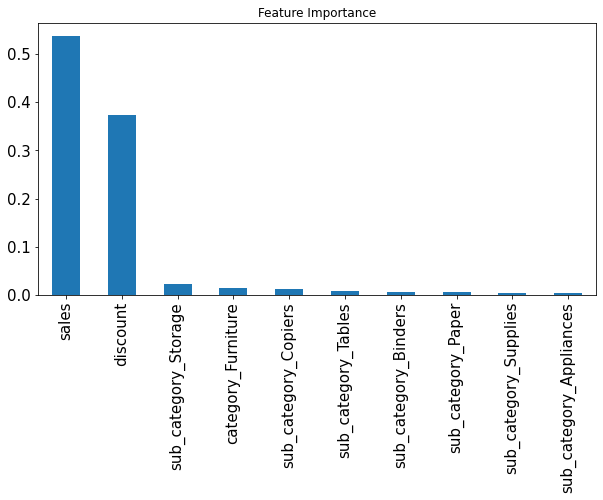

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.23039340275252, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=83, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)
R2_Score: 0.8980834671140636
MAE: 17.950476097748286
RMSE: 65.2063325600012


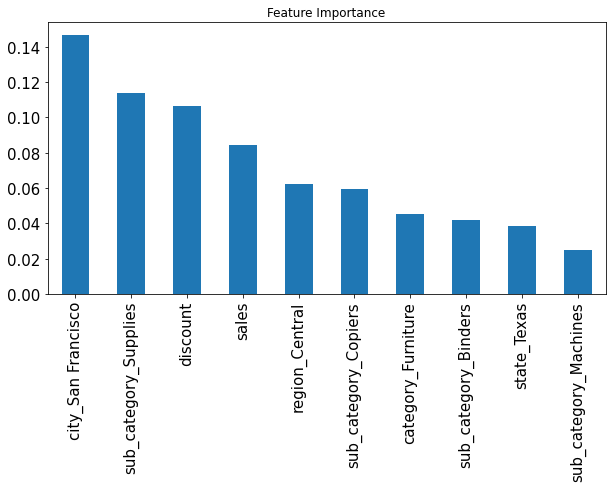

DecisionTreeRegressor(criterion='friedman_mse', max_features=0.8747529583903781,
                      random_state=42)
R2_Score: 0.8451052293558039
MAE: 21.849923031358884
RMSE: 80.3870019953718


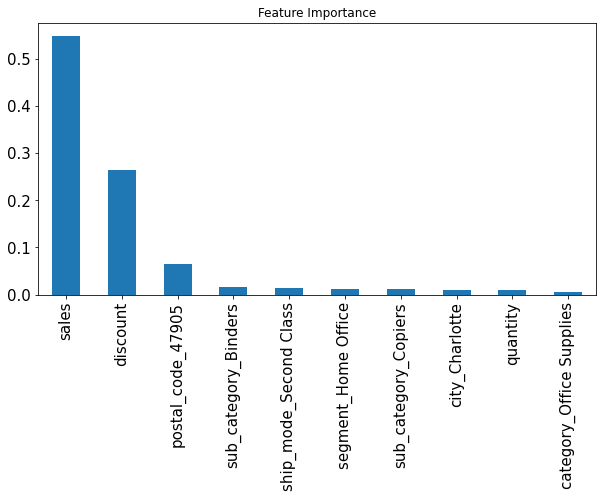

LinearRegression(n_jobs=1)
R2_Score: 0.5954272251108526
MAE: 54.18105954062997
RMSE: 129.9169395221684


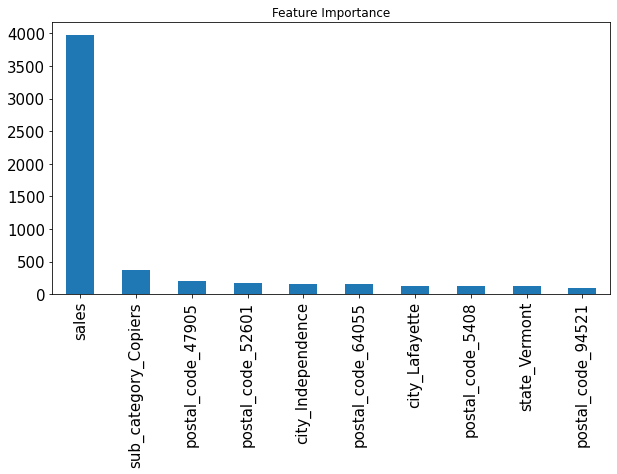

In [13]:
# select algorithms 
regressors = [
    GradientBoostingRegressor(alpha=0.8911746955969752,
                          learning_rate=0.04597766261006689,
                          loss='huber',
                          n_estimators=217,
                          random_state=42),
    XGBRegressor(learning_rate=0.23039340275252,
                 max_depth=6,
                 n_estimators=83,
                 random_state=42),
    DecisionTreeRegressor(criterion='friedman_mse',
                          max_features=0.8747529583903781,
                          random_state=42),
    LinearRegression(n_jobs=1)
]

# build model with every algorithm
for number, regressor in enumerate(regressors):
    pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor),
               ('regressor',regressor)
           ])
    model = pipeline.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # save predictions 
    name = 'pred_%s.npy' % number
    np.save(name, predictions)

    # evaluation
    print (regressor)
    print ('R2_Score:', r2_score(y_test, predictions))
    print ('MAE:',mean_absolute_error(y_test, predictions))
    print ('RMSE:',mean_squared_error(y_test, predictions, squared=False))
    
    # calculate feature importance 
    
    # get column names
    onehot_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features=categorical_features)

    # get feature importance of linear regression
    if number==3:
        feature_importance = pd.Series(data=pipeline.named_steps['regressor'].coef_, index = np.array(numeric_features + list(onehot_columns)))
    # get feature importance of other regressors
    else:
        feature_importance = pd.Series(data= pipeline.named_steps['regressor'].feature_importances_, index = np.array(numeric_features + list(onehot_columns)))

    # sort feature importance
    feature_importance = feature_importance.sort_values(ascending=False).head(10)
    
    # plot feature importance
    feature_importance.plot(kind='bar', fontsize=15, figsize=(10,5), title='Feature Importance')
    
    plt.show()


## Visualization of forecasts

This block visualizes the forecasts of the XGBoost and Linear Regression on a sample of 25 instances of the test dataset.

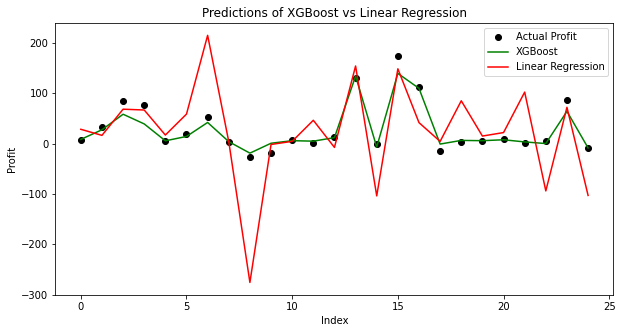

In [65]:
# load predictions
pred_xgb = np.load('pred_1.npy')
pred_linear = np.load('pred_3.npy')
y_test1 = pd.read_csv('y_test.dat')
y_test1 = y_test1['profit']

# filter first 25 predicted values  
pred_xgb = pred_xgb[:25]
pred_linear = pred_linear[:25]
y_test1 = y_test1.head(25)

# plot predictions vs actual profit 
plt.scatter(range(len(y_test1)), y_test1, color='black', label='Actual Profit')
plt.plot(range(len(pred_xgb)), pred_xgb, color='green', label='XGBoost')
plt.plot(range(len(pred_linear)), pred_linear, color='red', label='Linear Regression')
plt.title('Predictions of XGBoost vs Linear Regression')
plt.legend(loc='upper right')
plt.xlabel('Index')
plt.ylabel('Profit')
plt.rcParams["figure.figsize"] = (10,5)

plt.show()